In [2]:
# Needed to load cora
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch.optim as optim
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch_geometric'

In [21]:
# Loading the CORA dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
dataset

Processing...
Done!


Cora()

In [22]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Here,
*   x = node feature mtx(row wise BOW reprsntn of paper)
*   edge_index = graph connectivity
*   y = Labels
*   train_mask = boolean mask for deciding which nodes to be selected for training
*   val_mask = boolean mask for validation nodes
*   test_mask = boolean mask for test nodes



In [4]:
print(f"nodes: {data.num_nodes}")
print(f"features: {data.num_features}")
print(f"classes: {dataset.num_classes}")

nodes: 2708
features: 1433
classes: 7


In [23]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.2):
        super(GCN, self).__init__() # initializes in_chnl,hd_chnl,out_chnl, dropout
        # ip conv layer [2708,1433] -> [2708,16] per node
        self.conv1 = GCNConv(in_channels, hidden_channels)

        # self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # hidden conv layer [2708,16] -> [2708,7] per node
        self.conv2 = GCNConv(hidden_channels, out_channels)
        # 0.2 defalt
        self.dropout = dropout

    ## forward(node feature mtx, edge_idx):
    def forward(self, x, edge_index):
        # Applies GCNconv1 layer
        x = self.conv1(x, edge_index)
        #actvn fn
        x = F.relu(x)
        # drop around 20% nodes
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Aplies GCNconv2 layer
        x = self.conv2(x, edge_index)
        # return class wise log probabilites
        return F.log_softmax(x, dim=1)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
# in_channels, hidden_channels, out_channels
model = GCN(dataset.num_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #l2 reg = 0.0005

In [26]:
def train():
    model.train() # start training mode
    optimizer.zero_grad() # clear old gradients
    out = model(data.x, data.edge_index) # fwd pass of model
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) #neg LL for training data
    loss.backward() # calc gradient w backpropogation
    optimizer.step() # use adam created to update model wt
    pred = out.argmax(dim=1) # predicted class for node
    correct = pred[data.train_mask] == data.y[data.train_mask] # checks matching training pred vs ground truth
    acc = int(correct.sum()) / int(data.train_mask.sum()) # calc accuracy
    return loss.item(), acc


def test():
    model.eval() # set evaluation mode
    out = model(data.x, data.edge_index) # fwd pass on full graph
    loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]) # neg LL for testing data
    # testing accuracy calc
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return loss.item(), acc


In [27]:
train_losses = []
test_losses = []

best_loss = float('inf')
patience = 50
wait = 0

In [28]:
for epoch in range(500):
    train_loss, train_acc = train()
    test_loss, test_acc = test()

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1

    if epoch % 30 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")

    if wait == patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
        break


Epoch 0: Train Loss 1.9459, Train Acc 0.2214, Test Loss 1.9404, Test Acc 0.3350
Epoch 30: Train Loss 1.4560, Train Acc 0.9000, Test Loss 1.6654, Test Acc 0.7150
Epoch 60: Train Loss 0.7660, Train Acc 0.9571, Test Loss 1.2032, Test Acc 0.8000
Epoch 90: Train Loss 0.4607, Train Acc 0.9714, Test Loss 0.9523, Test Acc 0.8140
Epoch 120: Train Loss 0.3709, Train Acc 0.9929, Test Loss 0.8583, Test Acc 0.8050
Epoch 150: Train Loss 0.2989, Train Acc 0.9857, Test Loss 0.7965, Test Acc 0.8090
Epoch 180: Train Loss 0.2585, Train Acc 0.9929, Test Loss 0.7636, Test Acc 0.8120
Epoch 210: Train Loss 0.2271, Train Acc 1.0000, Test Loss 0.7477, Test Acc 0.8080
Epoch 240: Train Loss 0.2000, Train Acc 1.0000, Test Loss 0.7283, Test Acc 0.8110
Epoch 270: Train Loss 0.2167, Train Acc 0.9929, Test Loss 0.7215, Test Acc 0.8080
Epoch 300: Train Loss 0.1735, Train Acc 1.0000, Test Loss 0.7091, Test Acc 0.8110
Epoch 330: Train Loss 0.1699, Train Acc 1.0000, Test Loss 0.6996, Test Acc 0.8090
Epoch 360: Train Loss

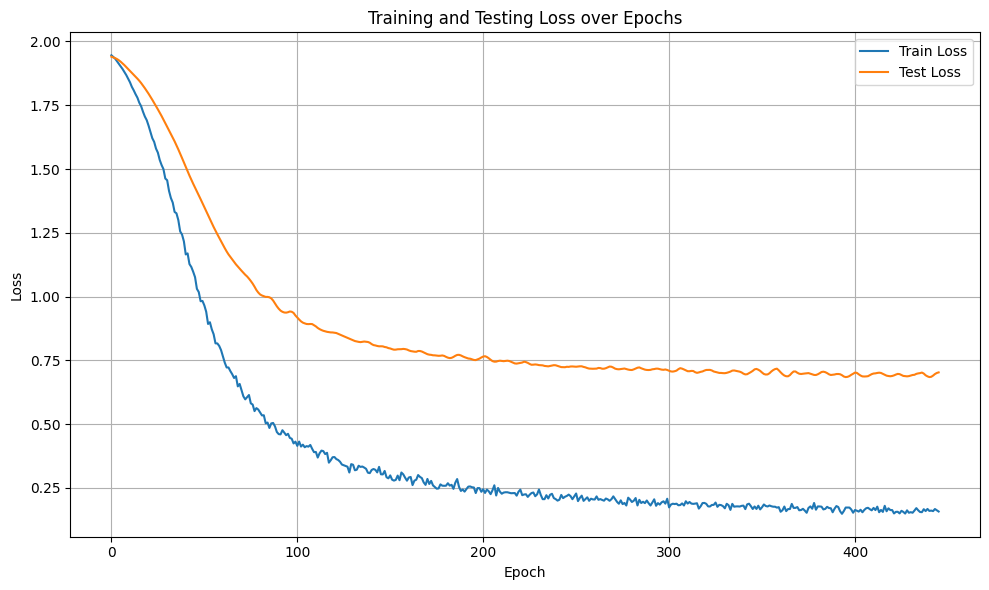

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [31]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

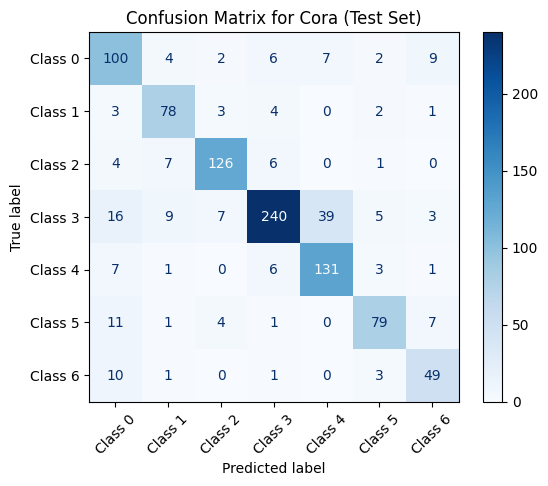

In [32]:
# Only evaluate on the test set
y_true = data.y[data.test_mask].cpu()
y_pred = pred[data.test_mask].cpu()

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(7)])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for Cora (Test Set)")
plt.show()

In [33]:
acc = cm.diagonal().sum() / cm.sum()
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8030


In [34]:
out = model(data.x, data.edge_index).cpu().detach().numpy() # fwd pass +numpy saving
# t-distributed Stochastic Neighbor Embedding... relationship repr at low dim(2D repr jere)
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(out)


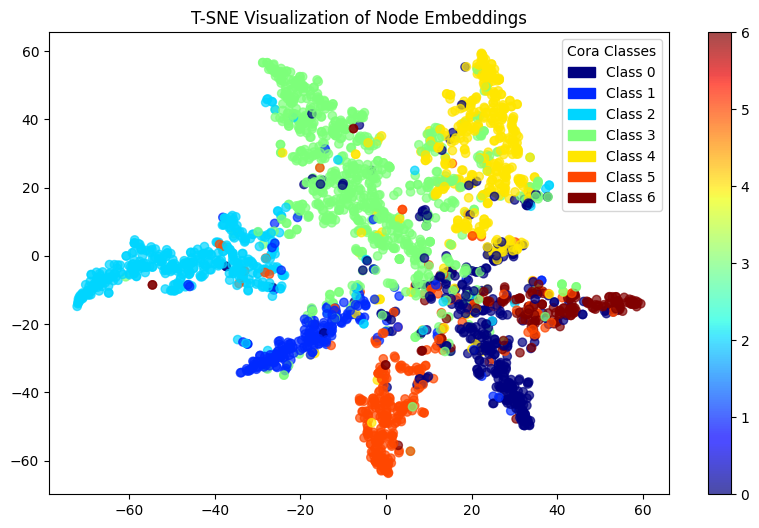

In [35]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=data.y.cpu(), cmap="jet", alpha=0.7)

# class wise legend and color mapping
classes = torch.unique(data.y)
num_classes = len(classes)
legend_handles = [
    mpatches.Patch(color=plt.cm.jet(int(i.item()) / (num_classes - 1)), label=f"Class {int(i.item())}")
    for i in classes.cpu()
]

plt.legend(handles=legend_handles, title="Cora Classes", loc="best")
plt.colorbar(scatter)
plt.title("T-SNE Visualization of Node Embeddings")
plt.show()


# Task 2: Generative Adversarial Network (GAN) Implementation (3 Marks)
1. Dataset: Use the CIFAR-10 dataset.
2. Task: Implement a Deep Convolutional GAN (DCGAN) to generate images.
3. Requirements:
    - Load and preprocess the dataset (normalize to [-1, 1]).
    - Implement a DCGAN with:
        ■ Generator (Conv2DTranspose layers).
        ■ Discriminator (Conv2D layers).
    - Train the GAN and generate sample images after every few epochs.
    - Plot the loss curves for generator and discriminator.


In [36]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to tensor
    transforms.Normalize((0.5,), (0.5,))  # mean = std = 0.5 ...ie shifts values from (0,1) -> (1,1)
])

In [37]:
# Load CIFAR-10 dataset
batch_size = 64
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [38]:
nn = torch.nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # upsamples noise vector[100,1,1] -> [512,4,4]
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # upsample to [256, 8, 8]
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # upsample to [128, 16, 16]
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # op of form [3, 32,32]...3 channel
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # op [-1, 1] to match training data
        )

    def forward(self, z):
        return self.net(z) # z = (batch_size,3,32,32)


In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # downsample/convolve [3, 32, 32] -> [128, 16, 16]
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # convolve to [256, 8, 8]
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # convolve to [512, 4, 4]
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # shrinks to a single no 0-1
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()  # op probability
        )

    def forward(self, img):
        return self.net(img).view(-1, 1) # real of fake pred

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
lr = 0.0005
beta1 = 0.5
epochs = 30

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [41]:
def count_parameters(model):
    # numel: no of element in tensor,  requires_grad = count trainable param
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

gen_params = count_parameters(generator)
disc_params = count_parameters(discriminator)

print(f"Total Generator Parameters: {gen_params:,}")
print(f"Total Discriminator Parameters: {disc_params:,}")

Total Generator Parameters: 3,449,475
Total Discriminator Parameters: 2,638,209


In [42]:
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)  # For visualizing progress

G_losses = []
D_losses = []


Epoch [1/30] Started...


Processing Batch 0/782...	Batch 0: Real Loss: 0.5791	Batch 0: Fake Loss: 0.8051	Batch 0: Generator Loss: 8.4091

Processing Batch 75/782...	Batch 100: Real Loss: 0.5232	Batch 100: Fake Loss: 0.0513	
Processing Batch 150/782...	Batch 200: Real Loss: 0.5235	Batch 200: Fake Loss: 0.6938	Batch 200: Generator Loss: 2.3816

Processing Batch 225/782...	
Processing Batch 300/782...	Batch 300: Real Loss: 0.0289	Batch 300: Fake Loss: 2.4306	
Processing Batch 375/782...	Batch 400: Real Loss: 0.1055	Batch 400: Fake Loss: 0.1205	Batch 400: Generator Loss: 3.4158

Processing Batch 450/782...	Batch 500: Real Loss: 0.1648	Batch 500: Fake Loss: 0.1278	
Processing Batch 525/782...	
Processing Batch 600/782...	Batch 600: Real Loss: 0.0780	Batch 600: Fake Loss: 0.0058	Batch 600: Generator Loss: 6.3744

Processing Batch 675/782...	Batch 700: Real Loss: 0.1160	Batch 700: Fake Loss: 0.0061	
Processing Batch 750/782...	
Epoch [1/30] Completed - Discriminator Loss: 1.4303 - Generator

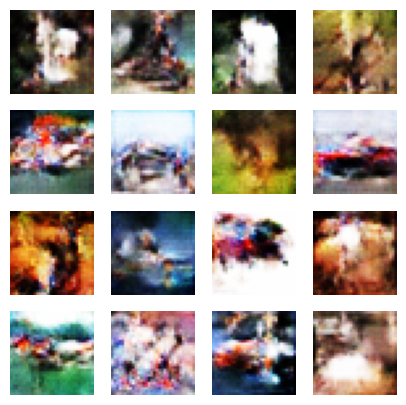


Epoch [6/30] Started...


Processing Batch 0/782...	Batch 0: Real Loss: 0.0438	Batch 0: Fake Loss: 0.2747	Batch 0: Generator Loss: 5.1936

Processing Batch 75/782...	Batch 100: Real Loss: 0.0548	Batch 100: Fake Loss: 0.0603	
Processing Batch 150/782...	Batch 200: Real Loss: 0.2368	Batch 200: Fake Loss: 0.3325	Batch 200: Generator Loss: 4.2840

Processing Batch 225/782...	
Processing Batch 300/782...	Batch 300: Real Loss: 0.2470	Batch 300: Fake Loss: 0.0338	
Processing Batch 375/782...	Batch 400: Real Loss: 0.1049	Batch 400: Fake Loss: 0.8087	Batch 400: Generator Loss: 5.5848

Processing Batch 450/782...	Batch 500: Real Loss: 0.1254	Batch 500: Fake Loss: 0.1873	
Processing Batch 525/782...	
Processing Batch 600/782...	Batch 600: Real Loss: 0.0157	Batch 600: Fake Loss: 0.5831	Batch 600: Generator Loss: 5.7040

Processing Batch 675/782...	Batch 700: Real Loss: 0.1888	Batch 700: Fake Loss: 0.1051	
Processing Batch 750/782...	
Epoch [6/30] Completed - Discriminator Loss: 0.5616 - Generator

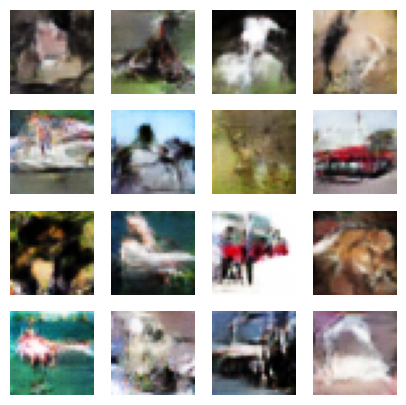


Epoch [11/30] Started...


Processing Batch 0/782...	Batch 0: Real Loss: 0.3661	Batch 0: Fake Loss: 0.0274	Batch 0: Generator Loss: 1.7556

Processing Batch 75/782...	Batch 100: Real Loss: 0.0259	Batch 100: Fake Loss: 0.3606	
Processing Batch 150/782...	Batch 200: Real Loss: 0.0525	Batch 200: Fake Loss: 0.1804	Batch 200: Generator Loss: 5.9132

Processing Batch 225/782...	
Processing Batch 300/782...	Batch 300: Real Loss: 0.2104	Batch 300: Fake Loss: 0.1675	
Processing Batch 375/782...	Batch 400: Real Loss: 0.2203	Batch 400: Fake Loss: 0.0550	Batch 400: Generator Loss: 2.5228

Processing Batch 450/782...	Batch 500: Real Loss: 0.1405	Batch 500: Fake Loss: 0.1804	
Processing Batch 525/782...	
Processing Batch 600/782...	Batch 600: Real Loss: 0.0291	Batch 600: Fake Loss: 0.1777	Batch 600: Generator Loss: 3.8033

Processing Batch 675/782...	Batch 700: Real Loss: 0.0903	Batch 700: Fake Loss: 0.1641	
Processing Batch 750/782...	
Epoch [11/30] Completed - Discriminator Loss: 0.4991 - Generat

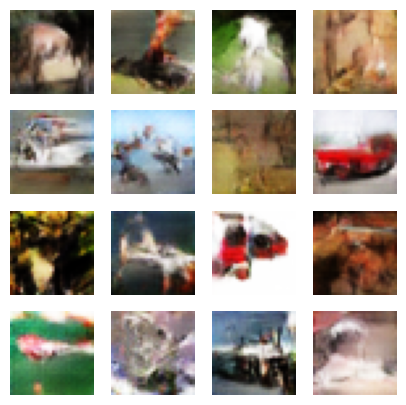


Epoch [16/30] Started...


Processing Batch 0/782...	Batch 0: Real Loss: 0.0080	Batch 0: Fake Loss: 1.1095	Batch 0: Generator Loss: 7.5213

Processing Batch 75/782...	Batch 100: Real Loss: 0.0327	Batch 100: Fake Loss: 0.2118	
Processing Batch 150/782...	Batch 200: Real Loss: 0.0852	Batch 200: Fake Loss: 0.4369	Batch 200: Generator Loss: 6.2948

Processing Batch 225/782...	
Processing Batch 300/782...	Batch 300: Real Loss: 0.7993	Batch 300: Fake Loss: 0.0312	
Processing Batch 375/782...	Batch 400: Real Loss: 0.1084	Batch 400: Fake Loss: 0.1138	Batch 400: Generator Loss: 4.4028

Processing Batch 450/782...	Batch 500: Real Loss: 0.1966	Batch 500: Fake Loss: 0.0286	
Processing Batch 525/782...	
Processing Batch 600/782...	Batch 600: Real Loss: 0.5541	Batch 600: Fake Loss: 1.3262	Batch 600: Generator Loss: 3.6621

Processing Batch 675/782...	Batch 700: Real Loss: 0.0147	Batch 700: Fake Loss: 0.8300	
Processing Batch 750/782...	
Epoch [16/30] Completed - Discriminator Loss: 0.0618 - Generat

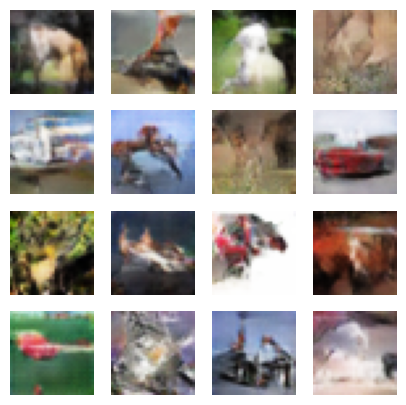


Epoch [21/30] Started...


Processing Batch 0/782...	Batch 0: Real Loss: 0.4144	Batch 0: Fake Loss: 0.0271	Batch 0: Generator Loss: 1.7565

Processing Batch 75/782...	Batch 100: Real Loss: 0.1171	Batch 100: Fake Loss: 0.0227	
Processing Batch 150/782...	Batch 200: Real Loss: 0.1423	Batch 200: Fake Loss: 0.0294	Batch 200: Generator Loss: 3.7112

Processing Batch 225/782...	
Processing Batch 300/782...	Batch 300: Real Loss: 0.0458	Batch 300: Fake Loss: 0.0804	
Processing Batch 375/782...	Batch 400: Real Loss: 0.0378	Batch 400: Fake Loss: 0.1301	Batch 400: Generator Loss: 4.1388

Processing Batch 450/782...	Batch 500: Real Loss: 0.3909	Batch 500: Fake Loss: 0.2288	
Processing Batch 525/782...	
Processing Batch 600/782...	Batch 600: Real Loss: 0.0330	Batch 600: Fake Loss: 0.2787	Batch 600: Generator Loss: 5.5004

Processing Batch 675/782...	Batch 700: Real Loss: 0.1000	Batch 700: Fake Loss: 0.1203	
Processing Batch 750/782...	
Epoch [21/30] Completed - Discriminator Loss: 0.0923 - Generat

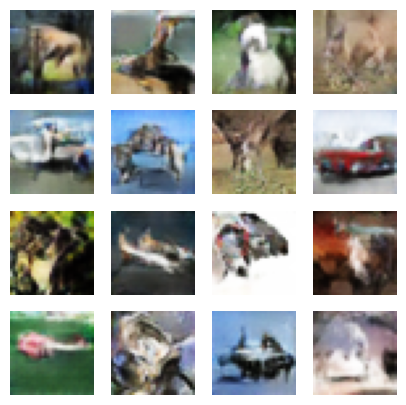


Epoch [26/30] Started...


Processing Batch 0/782...	Batch 0: Real Loss: 0.3260	Batch 0: Fake Loss: 0.0352	Batch 0: Generator Loss: 2.1371

Processing Batch 75/782...	Batch 100: Real Loss: 0.0102	Batch 100: Fake Loss: 0.2736	
Processing Batch 150/782...	Batch 200: Real Loss: 0.0477	Batch 200: Fake Loss: 0.0687	Batch 200: Generator Loss: 4.1769

Processing Batch 225/782...	
Processing Batch 300/782...	Batch 300: Real Loss: 0.0272	Batch 300: Fake Loss: 0.0688	
Processing Batch 375/782...	Batch 400: Real Loss: 0.2600	Batch 400: Fake Loss: 0.0119	Batch 400: Generator Loss: 3.2941

Processing Batch 450/782...	Batch 500: Real Loss: 0.0894	Batch 500: Fake Loss: 0.0536	
Processing Batch 525/782...	
Processing Batch 600/782...	Batch 600: Real Loss: 0.0175	Batch 600: Fake Loss: 0.1223	Batch 600: Generator Loss: 4.5605

Processing Batch 675/782...	Batch 700: Real Loss: 0.0542	Batch 700: Fake Loss: 0.0916	
Processing Batch 750/782...	
Epoch [26/30] Completed - Discriminator Loss: 0.0527 - Generat

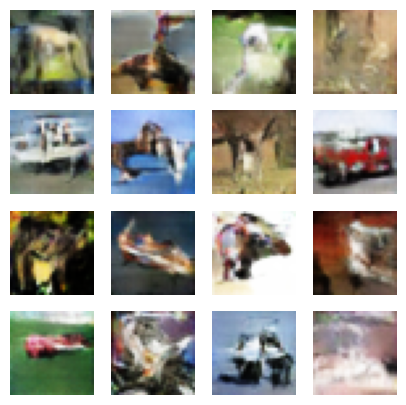

In [43]:
for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}] Started...\n")

    for i, (real_imgs, _) in enumerate(dataloader): # load batch of real img..labels not needed
        if i % 75 == 0:  # Print progress every 75 batches
            print(f"\nProcessing Batch {i}/{len(dataloader)}...",end="\t")

        real_imgs = real_imgs.to(device)

        # Labels
        real_labels = torch.ones(real_imgs.size(0), 1, device=device)
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), real_labels) # discr shud give closeness to 1 for real img
        if i % 100 == 0:
            print(f"Batch {i}: Real Loss: {real_loss.item():.4f}",end="\t")
        # data generated by generator
        noise = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)

        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels) # discr give closeness to  0 for fake img

        if i % 100 == 0:
            print(f"Batch {i}: Fake Loss: {fake_loss.item():.4f}",end="\t")

        D_loss = real_loss + fake_loss
        # bk propogation and step update
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # update generator weights based on difference from true value
        fake_output = discriminator(fake_imgs)
        G_loss = criterion(fake_output, real_labels)
        G_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:  # Print generator loss every 200 batches
            print(f"Batch {i}: Generator Loss: {G_loss.item():.4f}")

    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    print(f"\nEpoch [{epoch+1}/{epochs}] Completed - Discriminator Loss: {D_loss.item():.4f} - Generator Loss: {G_loss.item():.4f}\n")

    # Generate sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("Generating sample images...\n")
        with torch.no_grad():
            gen_imgs = generator(fixed_noise).cpu()
        fig, axes = plt.subplots(4, 4, figsize=(5, 5))
        for ax, img in zip(axes.flatten(), gen_imgs):
            ax.imshow((img.permute(1, 2, 0) * 0.5 + 0.5).numpy())  # Convert back to [0,1]
            ax.axis("off")
        plt.show()


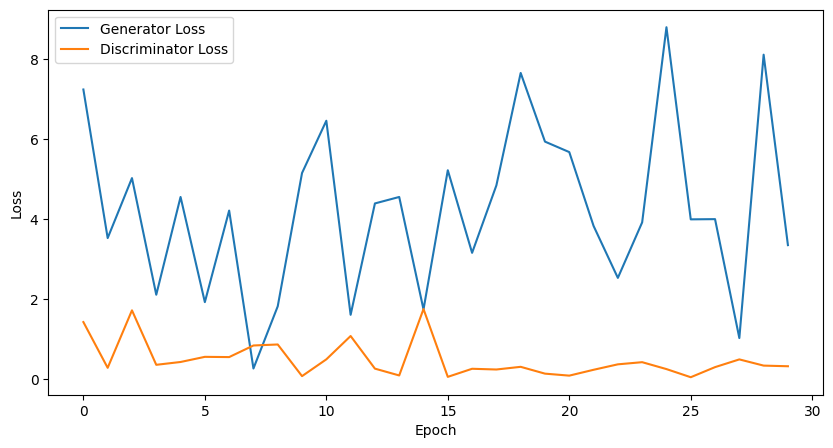

In [44]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Inference:

-  Generator loss:-
    - higher when the generator is producing unrealistic images that the discriminator easily rejects.
    - lower when it successfully fools the discriminator (i.e., discriminator thinks fake images are real).
    - spikes indicate points where generator is unable to fool discriminator

- Discriminator loss:-
    - low when it correctly classifies real and fake images.
    - high when it gets confused (thinks fake is real).


### __Conclusion:__ Currently Discriminator has better performance than genreator.


Task 3: Diffusion Model Implementation (4 Marks)
1. Dataset: Use the CIFAR-10 dataset.
2. Task: Implement a Denoising Diffusion Probabilistic Model (DDPM) for image
generation.
3. Requirements:
    - Load and preprocess the dataset (rescale to [-1, 1]).
    - Implement:
        ■ Forward diffusion process (gradually add Gaussian noise).
        ■ Reverse diffusion process (U-Net denoising model).
        ■ Train the model and generate samples at different noise levels.
    - Compare generated images with real images.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to tensor
    transforms.Normalize((0.5,), (0.5,))  # mean = std = 0.5 ...ie shifts values from (0,1) -> (1,1)
])

In [3]:
# Load CIFAR-10 dataset
batch_size = 128
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
import torch.nn as nn

In [5]:
# Check dataset shape
real_batch = next(iter(dataloader))
print(f"Dataset shape: {real_batch[0].shape}")


Dataset shape: torch.Size([128, 3, 32, 32])


In [2]:
F = torch.nn.functional

# Diffusion hyperparameters
T = 300  # Number of time steps
beta_start, beta_end = 0.0001, 0.02  # how much noise to be added at each step
betas = torch.linspace(beta_start, beta_end, T)  # Noise variance added per timestep
alphas = 1.0 - betas # signal to keep per timestep
alpha_cumprod = torch.cumprod(alphas, dim=0)  # Cumulative product...for exponential decay

In [6]:
print("betas:",betas[:5])
print("alphas:",alphas[:5])
print("cumulative prod alphas:", alpha_cumprod[:5])

betas: tensor([1.0000e-04, 1.6656e-04, 2.3311e-04, 2.9967e-04, 3.6622e-04])
alphas: tensor([0.9999, 0.9998, 0.9998, 0.9997, 0.9996])
cumulative prod alphas: tensor([0.9999, 0.9997, 0.9995, 0.9992, 0.9988])


In [7]:
def forward_diffusion(x_0, t):
    """Applies Gaussian noise at timestep t."""
    noise = torch.randn_like(x_0) # generate random noise
    # decides how much of original img remains
    sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod.to(t.device)[t])[:, None, None, None]
    # decides how much noise gets added
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt((1 - alpha_cumprod).to(t.device)[t])[:, None, None, None]
    # return noisy ver of img, noise added
    return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super(UNet, self).__init__()
        ## downsample....retain info w stride = 1 and then compress with stride = 2
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, stride=2, padding=1),
            nn.ReLU()
        )
        # bottleneck layer...expands features then compresses
        self.middle = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels, 3, stride=1, padding=1),
            nn.ReLU()
        )
        # upsamples img to original size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels, base_channels, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(base_channels, out_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss() # pred noise vs true noise

In [11]:
num_epochs = 30
for epoch in range(num_epochs):
    loop = tqdm(dataloader)
    total_loss = 0

    for x_0, _ in loop: #img, lbl
        x_0 = x_0.to(device)
        # for each img in batch sample a random timestep
        t = torch.randint(0, T, (x_0.shape[0],), device=device)
        # apply noise to img based on timestep
        x_t, noise = forward_diffusion(x_0, t)

        # Predict noise using x_t generated
        optimizer.zero_grad()
        predicted_noise = model(x_t)
        loss = criterion(predicted_noise, noise)
        # back propogation
        loss.backward()
        optimizer.step()
        # track per batch per epoch loss in op
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/30: 100%|██████████| 391/391 [00:15<00:00, 26.03it/s, loss=0.304]


Epoch 1 Loss: 0.4930


Epoch 2/30: 100%|██████████| 391/391 [00:18<00:00, 20.65it/s, loss=0.297]


Epoch 2 Loss: 0.3031


Epoch 3/30: 100%|██████████| 391/391 [00:17<00:00, 22.50it/s, loss=0.281]


Epoch 3 Loss: 0.2897


Epoch 4/30: 100%|██████████| 391/391 [00:15<00:00, 25.16it/s, loss=0.293]


Epoch 4 Loss: 0.2821


Epoch 5/30: 100%|██████████| 391/391 [00:15<00:00, 26.03it/s, loss=0.265]


Epoch 5 Loss: 0.2759


Epoch 6/30: 100%|██████████| 391/391 [00:19<00:00, 20.55it/s, loss=0.278]


Epoch 6 Loss: 0.2734


Epoch 7/30: 100%|██████████| 391/391 [00:15<00:00, 26.06it/s, loss=0.27]


Epoch 7 Loss: 0.2685


Epoch 8/30: 100%|██████████| 391/391 [00:16<00:00, 23.81it/s, loss=0.267]


Epoch 8 Loss: 0.2609


Epoch 9/30: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s, loss=0.232]


Epoch 9 Loss: 0.2528


Epoch 10/30: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s, loss=0.245]


Epoch 10 Loss: 0.2464


Epoch 11/30: 100%|██████████| 391/391 [00:16<00:00, 24.04it/s, loss=0.253]


Epoch 11 Loss: 0.2432


Epoch 12/30: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s, loss=0.236]


Epoch 12 Loss: 0.2406


Epoch 13/30: 100%|██████████| 391/391 [00:15<00:00, 25.05it/s, loss=0.245]


Epoch 13 Loss: 0.2375


Epoch 14/30: 100%|██████████| 391/391 [00:15<00:00, 25.38it/s, loss=0.231]


Epoch 14 Loss: 0.2373


Epoch 15/30: 100%|██████████| 391/391 [00:15<00:00, 25.74it/s, loss=0.235]


Epoch 15 Loss: 0.2355


Epoch 16/30: 100%|██████████| 391/391 [00:15<00:00, 24.94it/s, loss=0.228]


Epoch 16 Loss: 0.2350


Epoch 17/30: 100%|██████████| 391/391 [00:15<00:00, 25.64it/s, loss=0.224]


Epoch 17 Loss: 0.2339


Epoch 18/30: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s, loss=0.228]


Epoch 18 Loss: 0.2328


Epoch 19/30: 100%|██████████| 391/391 [00:17<00:00, 22.66it/s, loss=0.228]


Epoch 19 Loss: 0.2317


Epoch 20/30: 100%|██████████| 391/391 [00:17<00:00, 22.42it/s, loss=0.222]


Epoch 20 Loss: 0.2312


Epoch 21/30: 100%|██████████| 391/391 [00:15<00:00, 25.98it/s, loss=0.218]


Epoch 21 Loss: 0.2313


Epoch 22/30: 100%|██████████| 391/391 [00:15<00:00, 26.05it/s, loss=0.22]


Epoch 22 Loss: 0.2298


Epoch 23/30: 100%|██████████| 391/391 [00:15<00:00, 24.91it/s, loss=0.256]


Epoch 23 Loss: 0.2294


Epoch 24/30: 100%|██████████| 391/391 [00:15<00:00, 25.52it/s, loss=0.219]


Epoch 24 Loss: 0.2283


Epoch 25/30: 100%|██████████| 391/391 [00:15<00:00, 25.41it/s, loss=0.234]


Epoch 25 Loss: 0.2295


Epoch 26/30: 100%|██████████| 391/391 [00:16<00:00, 24.33it/s, loss=0.244]


Epoch 26 Loss: 0.2280


Epoch 27/30: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s, loss=0.228]


Epoch 27 Loss: 0.2277


Epoch 28/30: 100%|██████████| 391/391 [00:15<00:00, 24.47it/s, loss=0.225]


Epoch 28 Loss: 0.2276


Epoch 29/30: 100%|██████████| 391/391 [00:16<00:00, 23.97it/s, loss=0.231]


Epoch 29 Loss: 0.2273


Epoch 30/30: 100%|██████████| 391/391 [00:15<00:00, 25.95it/s, loss=0.218]

Epoch 30 Loss: 0.2271


In [10]:
def visualize_noisy_images(x_0, timesteps):
    fig, axs = plt.subplots(1, len(timesteps), figsize=(15, 3))
    for i, t in enumerate(timesteps):
        t_batch = torch.tensor([t]*x_0.shape[0], device=device)
        noisy_img, _ = forward_diffusion(x_0, t_batch) # apply noise
        img = noisy_img[0].cpu().permute(1, 2, 0)
        axs[i].imshow((img * 0.5 + 0.5).clamp(0, 1).numpy()) #show noisy img
        axs[i].set_title(f"t = {t}")
        axs[i].axis("off")
    plt.show()


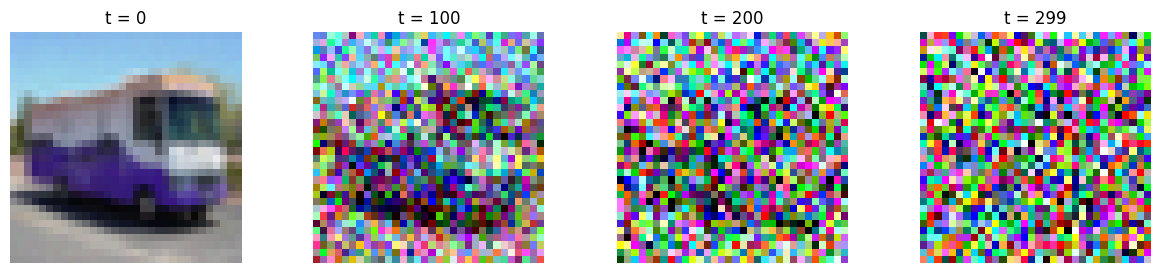

In [56]:
# Sampling w a real img
sample_real_image, _ = next(iter(dataloader))
sample_real_image = sample_real_image[0].to(device)
# Visualize noisy injection at various timesteps
visualize_noisy_images(sample_real_image, [0, 100, 200, 299])


In [57]:
def reverse_diffusion(model, img_size=(3, 32, 32)):
    """Samples from the learned distribution using the trained U-Net."""
    x_t = torch.randn((1, *img_size), device=device)  # Start from pure noise
    model.eval()

    with torch.no_grad():
        for t in range(T-1, 0, -1):
            t_tensor = torch.tensor([t], device=device)
            predicted_noise = model(x_t)
            alpha_t = alphas[t]
            alpha_cumprod_t = alpha_cumprod[t]
            # posterior mean formula in DDPM
            # subtract predicted noise and scale it make it move towards the actual img
            x_t = (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_t)
            # maintain randomness at each reverse step
            if t > 1:
                noise = torch.randn_like(x_t)
                x_t += torch.sqrt(betas[t]) * noise

    return x_t.cpu()




In [62]:
def compare_generated_vs_real(model, real_img):
    generated = reverse_diffusion(model)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Real image
    axs[0].imshow((real_img.squeeze(0).permute(1, 2, 0).cpu() * 0.5 + 0.5).clamp(0, 1).numpy())
    axs[0].set_title("Real Image")
    axs[0].axis("off")

    # Generated image
    axs[1].imshow((generated.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1).numpy())
    axs[1].set_title("Generated Image")
    axs[1].axis("off")

    plt.show()


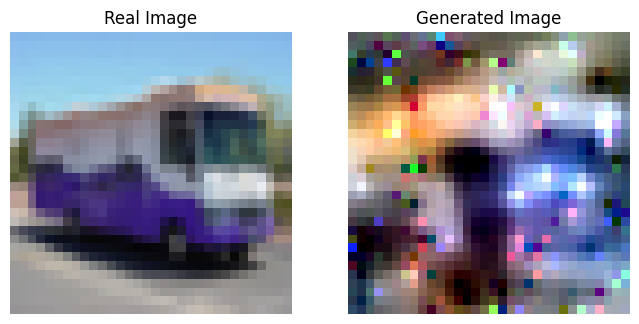

In [63]:
# Compare generated image to the real one
compare_generated_vs_real(model, sample_real_image)